In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
import numpy as np
from tqdm import tqdm
from collections import Counter

In [61]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib.cm as cm
%matplotlib inline

In [4]:
np.random.seed(1)

T = 40
L = 200
N = 2000

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
labels = np.random.randint(2, size=N) * 2 - 1
waves = np.sin((x.T / ((np.random.rand(N)**2)*T + 2)).T).astype('float64').reshape(N, L, 1)

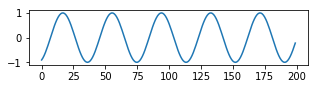

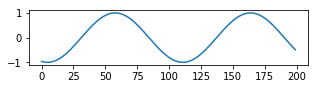

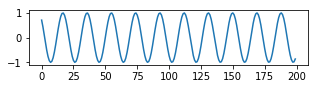

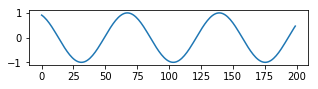

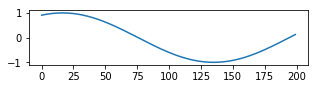

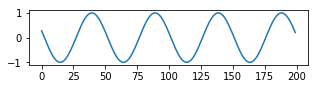

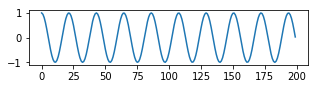

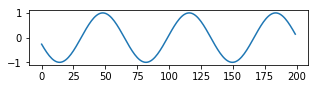

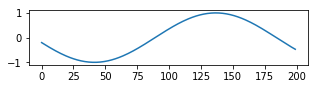

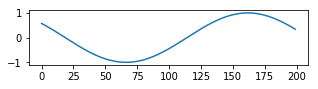

In [5]:
for i in range(10):
    plt.figure(figsize=(5, 1))
    plt.plot(waves[i])

In [6]:
target_features = ['w', 'rw']

In [7]:
lwaves = np.array([waves[i] if labels[i] == 1 else waves[i]*(-1) for i in range(N)])
rwaves = np.array(waves)

In [8]:
data = np.stack((rwaves, lwaves), axis=2).squeeze()

IndexError: index 2 is out of bounds for axis 2 with size 2

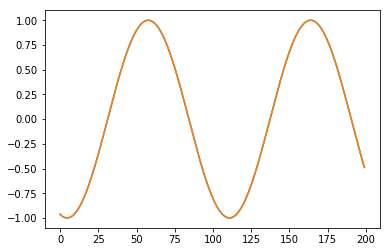

In [9]:
plt.plot(data[1, :, 0])
plt.plot(data[1, :, 1])
plt.plot(data[1, :, 2])
plt.title(labels[1])

In [ ]:
plt.plot(data[3, :, 0])
plt.plot(data[3, :, 1])
plt.plot(data[3, :, 2])
plt.title(labels[3])

## standartize slices features

In [10]:
Counter(labels)

Counter({1: 1025, -1: 975})

In [11]:
label_id = {}
for label in Counter(labels):
    if label != 'nan':
        label_id[label] = len(label_id)
num_labels = len(label_id)
label_id['nan'] = num_labels
num_labels

2

In [12]:
N = len(data)
N

2000

In [13]:
label_id

{1: 0, -1: 1, 'nan': 2}

In [14]:
full_labels = np.array([label_id[label] for label in labels])
corrupted_labels = np.array(full_labels)
np.random.seed(0)
corrupted_labels[np.random.choice(len(corrupted_labels), int(0.75*len(corrupted_labels)), replace=False)] = num_labels

In [15]:
Counter(full_labels)

Counter({0: 1025, 1: 975})

In [16]:
Counter(corrupted_labels)

Counter({2: 1500, 0: 256, 1: 244})

## prepare a dataloader for the model

In [17]:
batch_size = 512

In [18]:
device = torch.device("cuda")

In [19]:
train_inds = np.arange(int(N*5/6))
test_inds = np.arange(int(N*5/6), N)

In [20]:
len(train_inds), len(test_inds)

(1666, 334)

In [21]:
data_tensor = torch.stack([torch.Tensor(x) for x in data])

In [22]:
corrupted_labels_tensor = torch.Tensor(corrupted_labels).long()
full_labels_tensor = torch.Tensor(full_labels).long()

In [23]:
ts_dataset_train = torch.utils.data.TensorDataset(data_tensor[train_inds], 
                                                  corrupted_labels_tensor[train_inds], 
                                                  full_labels_tensor[train_inds])
ts_dataset_test = torch.utils.data.TensorDataset(data_tensor[test_inds], 
                                                 corrupted_labels_tensor[test_inds], 
                                                 full_labels_tensor[test_inds])

In [24]:
train_loader = torch.utils.data.DataLoader(ts_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ts_dataset_test, batch_size=batch_size, shuffle=True)



<img src="m2_vae.png" alt="drawing" style="width:500px;"/>

In [365]:
# Semi-Supervised VAE model

class SSVAE(nn.Module):
    def __init__(self, in_channels, M, K=12, P=5, mp=3, hidden_lsz=2, channels=10, lstm_sz=10,
                clf_sz=50, is_semi_supervised=True):
        super(SSVAE, self).__init__()
        self.M = M
        self.channels = channels
        #self.preprocess = nn.LSTM(in_channels, lstm_sz, num_layers=2)
        #self.fc0 = nn.Linear(lstm_sz, in_channels)
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=channels, kernel_size=K, padding=P)
        #self.mp1 = nn.MaxPool1d(kernel_size=mp, stride=mp, return_indices=True)
        self.mp1 = nn.MaxPool1d(kernel_size=mp, stride=mp, return_indices=False)
        conv_sz = self.conv1.out_channels * ((L + 1 - (K - 2*P)) // mp)
        print('conv size:', conv_sz)
        self.fc21 = nn.Linear(conv_sz, hidden_lsz)
        self.fc22 = nn.Linear(conv_sz, hidden_lsz)
        r = hidden_lsz + M * int(is_semi_supervised)
        self.fc3 = nn.Linear(r, channels*r)
        print('fc3', r, channels*r)
        self.fc3b = nn.Linear(channels*r, conv_sz)
        self.ump4 = nn.MaxUnpool1d(kernel_size=mp, stride=mp)
        self.ump4_inds_base = torch.tensor(np.arange(mp//2, (L + 1 - (K - 2*P)) - 1, mp)).float()
        self.deconv4 = nn.ConvTranspose1d(in_channels=channels, out_channels=in_channels, kernel_size=K, padding=P)
        
        self.polish = nn.LSTM(in_channels, lstm_sz, num_layers=1, bidirectional=True)
        self.fc4 = nn.Linear(2*lstm_sz, in_channels)
        
        
        self.clf_conv1 = nn.Conv1d(in_channels=in_channels, out_channels=channels, kernel_size=K, padding=P)
        self.clf_mp1 = nn.MaxPool1d(kernel_size=mp, stride=mp, return_indices=False)
        self.clf_linear = nn.Linear(conv_sz, clf_sz)
        self.clf_final = nn.Linear(clf_sz, M)
        #self.theta = torch.nn.Parameter(torch.randn(M, in_channels)) # class-dependent channel weights for MSE
        self.theta = torch.tensor(np.array([[-5, 2.5, 2.5], [5, -2.5, -2.5]])).float()
        self.is_semi_supervised = is_semi_supervised

    def encode(self, x):
        #print('encode', x.shape)
        #h1, self.mp1_inds = self.mp1(F.relu(self.conv1(x)))
        #h0, _ = self.preprocess(x.transpose(1, 0).transpose(2, 0))
        #print(h0.shape)
        #prox = self.fc0(F.relu(h0)).transpose(2, 0).transpose(1, 0)
        #print(prox.shape)
        #h1 = self.mp1(F.relu(self.conv1(prox)))
        h1 = self.mp1(F.leaky_relu(self.conv1(x)))
        h1 = h1.view(h1.shape[0], -1)
        return self.fc21(h1), self.fc22(h1)
    
    def classify(self, x):
        #print('classify', x.shape)
        h1 = self.clf_mp1(F.leaky_relu(self.clf_conv1(x)))
        h1 = h1.view(h1.shape[0], -1)
        h2 = F.leaky_relu(self.clf_linear(h1))
        return torch.log_softmax(self.clf_final(h2), dim=1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar) + 0.1
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z, y):
        if self.is_semi_supervised:
            zy = torch.cat((z, y), dim=1)
        else:
            zy = z
            
        zyb = F.leaky_relu(self.fc3(zy))
        #print(torch.isnan(zy).any())
        ump4_inds = (torch.ones(z.shape[0], self.channels, len(self.ump4_inds_base)) * self.ump4_inds_base).long().to(device)
        h3 = self.ump4(F.leaky_relu(self.fc3b(zyb).unsqueeze(1).view(zy.shape[0], self.deconv4.in_channels, -1)),
                       ump4_inds)
        #print(torch.isnan(self.fc3(zy)).any())
        #print(torch.isnan(h3).any())
        
        h4 = F.leaky_relu(self.deconv4(h3))
        #print(h4.shape)
        h4 = h4.transpose(1, 0).transpose(2, 0) 
        #h4 = h4 + torch.randn(h4.shape)*1e-5
        #print(torch.isnan(h4).any())
        h5, _ = self.polish(h4)
        h5 = F.leaky_relu(h5)
        #h5 = F.leaky_relu(self.polish(h4))
        #print(torch.isnan(h5).any())
        #return h4.transpose(1, 2)#.squeeze()
        return self.fc4(h5).transpose(1, 0).squeeze()
    
    
    
    def forward(self, x, variational_sample=1):
        mu, logvar = self.encode(x.transpose(1, 2))
        y_pred = self.classify(x.transpose(1, 2))
        for i in range(variational_sample):
            z = self.reparameterize(mu, logvar)
            recon_x = self.decode(z, y_pred)
            if i == 0:
                reconstruction = torch.zeros_like(recon_x)
            reconstruction += recon_x
        reconstruction /= variational_sample
        #print(torch.isnan(reconstruction).any())
        return reconstruction, mu, logvar, y_pred


In [357]:
def loss_component_KLD(mu, logvar):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

In [358]:
def semi_supervised_cross_entorpy(y, log_p):
    # for missing labels all one-hot-y is 0
    return -torch.sum(y * log_p)/(torch.sum(y) + 1e-5)

In [359]:
def weighted_mse_loss(rx, x, wy, y_pred):
    # wy = torch.softmax(model.theta, dim=1)
    MSE_channels = torch.sum((rx - x)**2, dim=1) 
    return torch.sum(MSE_channels)/x.shape[0]#/(x.shape[0]*x.shape[1])

In [317]:
def torch_var(x):
    return torch.autograd.Variable(torch.from_numpy(np.array(x)).float())

In [367]:
class SemiSupervisedLoss(torch.nn.Module):
    
    def __init__(self, mse_weight=50, ce_weight=600, kl_weight=0.5, is_semi_supervised=True):
        super(SemiSupervisedLoss, self).__init__()
        self.mse_weight = mse_weight
        self.ce_weight = ce_weight * int(is_semi_supervised)
        self.kl_weight = kl_weight
        
    def forward(self, recon_x, x, y_true, y_pred, mu, logvar, wy):
        MSE = weighted_mse_loss(recon_x, x, wy, y_pred) * self.mse_weight
        CrossEntropy = semi_supervised_cross_entorpy(y_true, y_pred)
        #MSE = torch.sum((recon_x - x)**2)/10
        #MSE = nn.MSELoss(reduction='sum')(recon_x, x)/10
        return MSE + CrossEntropy*self.ce_weight + loss_component_KLD(mu, logvar)*self.kl_weight

In [319]:
def loss_function(recon_x, x, y_true, y_pred, mu, logvar, wy):
    return SemiSupervisedLoss(is_semi_supervised=(SS_MOD is not None))(recon_x, x, y_true, y_pred, mu, logvar, wy)

In [320]:
def one_hot_encoding(y):
    one_hot_labels = torch.zeros(len(y), num_labels + 1)
    one_hot_labels.scatter_(1, torch.tensor(y).view(-1, 1), 1)
    return one_hot_labels[:, :-1]

In [321]:
def train(model, optimizer, epoch, max_batches=2):
    model.train()
    train_loss = 0
    mse_loss = 0
    crossentopy_loss = 0
    crossentopy_loss_full = 0
    kld = 0
    for batch_idx, (data, y_true, y_full) in enumerate(train_loader):
        one_hot_labels_full = one_hot_encoding(y_full).to(device)
        if SS_MOD == 'full':
            one_hot_labels = one_hot_encoding(y_full)
        elif SS_MOD == 'semi':
            one_hot_labels = one_hot_encoding(y_true)
        else:
            one_hot_labels = one_hot_encoding(y_true) * 0
        data = data.to(device)
        cur_batch_size = len(data)
        one_hot_labels = one_hot_labels.to(device)
        #print(data.shape, y_true.shape)
            
        #print(data.shape)
        optimizer.zero_grad()
        recon_batch, mu, logvar, y_pred = model(data)
        #print(one_hot_labels.shape, y_pred.shape)
        
        #print('mu', mu.shape)
        #print(recon_batch.shape, data[:, :recon_batch.shape[1]].shape)
        loss = loss_function(recon_batch, 
                             data[:, :recon_batch.shape[1]],
                             one_hot_labels, y_pred,
                             mu, logvar, torch.softmax(model.theta, dim=1))
        if VERBOSE:
            mse_loss += weighted_mse_loss(recon_batch, 
                                          data[:, :recon_batch.shape[1]],
                                     torch.softmax(model.theta, dim=1),
                                     y_pred)
            if y_pred is not None:
                crossentopy_loss += semi_supervised_cross_entorpy(one_hot_labels, y_pred)
                crossentopy_loss_full += semi_supervised_cross_entorpy(one_hot_labels_full, y_pred)
            kld += loss_component_KLD(mu, logvar)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx >= max_batches:
            break
    train_loss /= (batch_idx + 1)
    if VERBOSE:
        mse_loss /= (batch_idx + 1)
        crossentopy_loss /= (batch_idx + 1)
        crossentopy_loss_full /= (batch_idx + 1)
        kld /= (batch_idx + 1)
        if epoch % 10 == 0:
            print('====> Train set loss: {:.4f}, MSE: {:.4f}, CE: {:.4f}, CE(full): {:.4f}, KL: {:.4f}'.format(train_loss, mse_loss, crossentopy_loss, crossentopy_loss_full, kld))
    
    return train_loss

In [322]:
def plot_comparison(x, x_recon):
    plt.figure(figsize=(5, 1.25*x.shape[1]))
    for f in range(x.shape[1]):
        plt.subplot(x.shape[1], 1, f + 1)
        plt.plot(x[:, f].data.numpy().ravel())
        plt.plot(x_recon[:, f].data.numpy().ravel())
        plt.ylabel(target_features[f])
    plt.tight_layout()

In [323]:
def plot_comparison_batch(X, X_recon, y_true, y_pred, file_path):
    #print(X.shape)
    plt.figure(figsize=(5*len(X), 1.25*X.shape[2]))
    for i in range(len(X)):
        x_recon = X_recon[i]
        x = X[i, :len(x_recon)]
        
        for f in range(x.shape[1]):
            plt.subplot(x.shape[1], len(X), f*len(X) + i + 1)
            if f == 0:
                mse = nn.MSELoss(reduction='sum')(x.view(-1, 1), x_recon.view(-1, 1)).item()/len(x)
                plt.title('example {}\nMSE: {:.3f}, y_true: {}\n y_pred: '.format(i + 1, mse, y_true[i]) + ', '.join(['%.4f' % np.exp(y) for y in y_pred[i].data.numpy()]))
            plt.plot(x[:, f].data.numpy().ravel())
            plt.plot(x_recon[:, f].data.numpy().ravel())
            plt.ylabel(target_features[f])
            plt.ylim(X[:, :, f].min().item(), X[:, :, f].max().item())
    plt.tight_layout()
    plt.savefig(file_path, bbox_inches='tight', dpi=100)
    plt.close()

In [324]:
from sklearn.metrics import roc_auc_score

In [325]:
def safe_roc_auc_score(y, p):
    if len(np.unique(y)) == 1:
        return np.nan
    else:
        return roc_auc_score(y, p)

In [383]:
def test(model, epoch, recon_samples=10):
    model.eval()
    test_loss = 0
    mse_loss = 0
    crossentopy_loss = 0
    crossentopy_loss_full = 0
    kld = 0
    full_vals = []
    pred_vals = []
    with torch.no_grad():
        for batch_idx, (data, y_true, y_full) in enumerate(test_loader):
            if SS_MOD == 'full':
                one_hot_labels = one_hot_encoding(y_full)
            elif SS_MOD == 'semi':
                one_hot_labels = one_hot_encoding(y_true)
            else:
                one_hot_labels = one_hot_encoding(y_true) * 0
            one_hot_labels_full = one_hot_encoding(y_full).to(device)
            full_vals.extend(one_hot_labels_full.to(torch.device("cpu")).data.numpy().tolist())
            data = data.to(device)
            one_hot_labels = one_hot_labels.to(device)
            cur_batch_size = len(data)
            for r in range(recon_samples):
                recon_batch_part, mu, logvar, y_pred = model(data)
                if r == 0:
                    recon_batch = recon_batch_part
                else:
                    recon_batch += recon_batch_part
            recon_batch /= recon_samples
            if y_pred is not None:
                pred_vals.extend(np.exp(y_pred.to(torch.device("cpu")).data.numpy()).tolist())
            test_loss += loss_function(recon_batch, 
                                       data[:, :recon_batch.shape[1]], 
                                       one_hot_labels, y_pred,
                                       mu, logvar, torch.softmax(model.theta, dim=1)).item()
            if True:
                mse_loss += weighted_mse_loss(recon_batch, 
                                          data[:, :recon_batch.shape[1]],
                                          torch.softmax(model.theta, dim=1),
                                          y_pred)
                if y_pred is not None:
                    crossentopy_loss += semi_supervised_cross_entorpy(one_hot_labels, y_pred)
                    crossentopy_loss_full += semi_supervised_cross_entorpy(one_hot_labels_full, y_pred)
                kld += loss_component_KLD(mu, logvar)
                if batch_idx == 0 and VERBOSE:
                    n = min(data.size(0), 8)
                    if y_pred is None:
                        y_pred = torch.zeros(n, num_labels)
                    plot_comparison_batch(data[:n, :recon_batch.shape[1]].to(torch.device("cpu")), 
                                          recon_batch[:n].to(torch.device("cpu")), 
                                          y_full[:n].to(torch.device("cpu")), 
                                          y_pred[:n].to(torch.device("cpu")), 
                             'results/mwd_recon_' + str(epoch) + '.png')

    test_loss /= (batch_idx + 1)
    if True:    
        mse_loss /= (batch_idx + 1)
        crossentopy_loss /= (batch_idx + 1)
        crossentopy_loss_full /= (batch_idx + 1)
        kld /= (batch_idx + 1)
        print('====> Test set loss: {:.4f}, MSE: {:.4f}, CE: {:.4f}, CE(full): {:.4f}, KL: {:.4f}'.format(test_loss, mse_loss, crossentopy_loss, crossentopy_loss_full, kld))
        if len(pred_vals) == len(full_vals):
            full_vals = np.array(full_vals)
            pred_vals = np.array(pred_vals)
            for c in range(num_labels):
                print(safe_roc_auc_score(full_vals[:, c], pred_vals[:, c]))
    return test_loss

In [384]:
epochs = 1000

In [385]:
def fit_model_report(test_rate=100):
    model = SSVAE(in_channels=len(target_features), M=num_labels, K=20, P=10, hidden_lsz=latent_dim, channels=5, 
              mp=3, lstm_sz=10, clf_sz=10, is_semi_supervised=(SS_MOD is not None)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    if VERBOSE:
        print('number of model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))
    train_losses = []
    test_losses = []
    for epoch in range(1, epochs + 1):
        t = train(model, optimizer, epoch, max_batches=30)
        if epoch % test_rate == 0:
            print('epoch:', epoch)
            train_losses.append(t)
            test_losses.append(test(model, epoch))
    
    return model, train_losses, test_losses

In [386]:
# SS_MOD : None, 'full', 'semi', 'rand'

In [387]:
LOGS = 5

In [388]:
latent_dim = 2
SS_MOD = 'full'
VERBOSE = False

In [389]:
full_log = []
for _ in range(LOGS):
    m, trl, tel = fit_model_report(100)
    full_log.append((m, trl, tel))

conv size: 335
fc3 4 20
epoch: 100
====> Test set loss: 8699.1533, MSE: 169.0852, CE: 0.1569, CE(full): 0.1569, KL: 301.4516
1.0
1.0
epoch: 200
====> Test set loss: 8022.0640, MSE: 155.4702, CE: 0.1048, CE(full): 0.1048, KL: 371.3807
1.0
1.0
epoch: 300
====> Test set loss: 7212.8936, MSE: 136.9427, CE: 0.0931, CE(full): 0.0931, KL: 619.7659
1.0
1.0
epoch: 400
====> Test set loss: 6127.2520, MSE: 112.2217, CE: 0.0729, CE(full): 0.0729, KL: 944.9147
1.0
1.0
epoch: 500
====> Test set loss: 5950.1533, MSE: 108.1650, CE: 0.0677, CE(full): 0.0677, KL: 1002.5621
1.0
1.0
epoch: 600
====> Test set loss: 5637.7998, MSE: 101.4672, CE: 0.0679, CE(full): 0.0679, KL: 1047.4486
1.0
1.0
epoch: 700
====> Test set loss: 5402.2231, MSE: 96.5760, CE: 0.0672, CE(full): 0.0672, KL: 1066.2434
1.0
1.0
epoch: 800
====> Test set loss: 5287.6611, MSE: 93.9873, CE: 0.0658, CE(full): 0.0658, KL: 1097.6647
1.0
1.0
epoch: 900
====> Test set loss: 5344.1416, MSE: 95.1330, CE: 0.0637, CE(full): 0.0637, KL: 1098.5973
1

Text(0,0.5,'~ELBO')

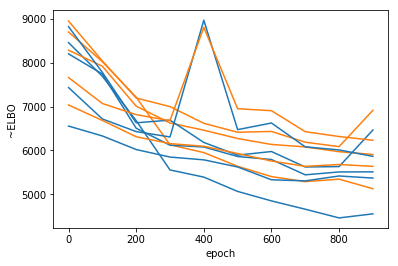

In [390]:
for i in range(LOGS):
    m, trl, tel = full_log[i]
    plt.plot(range(0, epochs, 100), trl, color='C0')
    plt.plot(range(0, epochs, 100), tel, color='C1')
plt.xlabel('epoch')
plt.ylabel('~ELBO')

In [463]:
def plot2d_latent(log, fname, title=None):
    if title is None:
        title=fname
    plt.figure(figsize=(3*LOGS, 3))
    for i in range(LOGS):
        plt.subplot(1, LOGS, i + 1)
        m, trl, tel = log[i]
        _, mu, logvar, _ = m(ts_dataset_train[:len(ts_dataset_train)][0].to(device))
        plt.scatter(mu.to(torch.device("cpu")).data.numpy()[:, 0], mu.to(torch.device("cpu")).data.numpy()[:, 1], 
                    s=2, c=ts_dataset_train[:len(ts_dataset_train)][2], cmap=cm.rainbow)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('z0')
        plt.ylabel('z1')

        plt.title(f'seed: {i}')
    plt.suptitle(title, fontsize=16, y=1.05)
    plt.tight_layout()
    plt.savefig(f'{fname}.png', dpi=300, bbox_to_anchor=(1, 1), bbox_extra_artists=(lgd,), bbox_inches='tight')

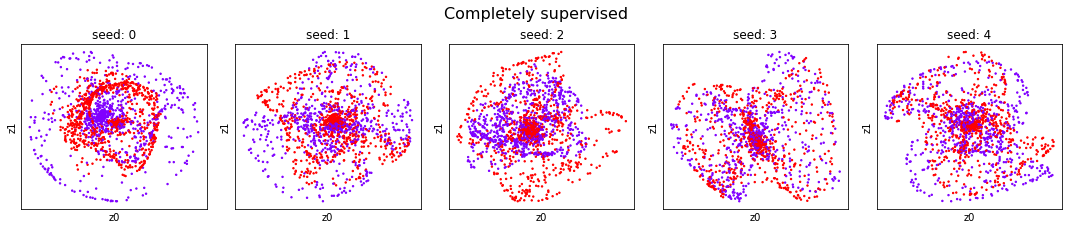

In [464]:
plot2d_latent(full_log, 'full_latent', 'Completely supervised')

In [373]:
VERBOSE = True
test(m, 500, recon_samples=10)

====> Test set loss: 5593.1494, MSE: 101.2555, CE: 0.0243, CE(full): 0.0243, KL: 1031.5277
1.0
1.0


5593.1494140625

In [392]:
latent_dim = 2
SS_MOD = 'semi'

In [393]:
semi_log = []
for _ in range(LOGS):
    m, trl, tel = fit_model_report(100)
    semi_log.append((m, trl, tel))

conv size: 335
fc3 4 20
epoch: 100
====> Test set loss: 7499.8838, MSE: 142.2704, CE: 0.0022, CE(full): 0.0029, KL: 770.0855
1.0
1.0
epoch: 200
====> Test set loss: 6647.9287, MSE: 123.3881, CE: 0.0026, CE(full): 0.0040, KL: 953.9104
1.0
1.0
epoch: 300
====> Test set loss: 6375.8037, MSE: 117.4629, CE: 0.0030, CE(full): 0.0047, KL: 1001.7237
1.0
1.0
epoch: 400
====> Test set loss: 6194.2432, MSE: 113.5121, CE: 0.0036, CE(full): 0.0053, KL: 1032.9985
1.0
1.0
epoch: 500
====> Test set loss: 6060.6406, MSE: 110.5782, CE: 0.0027, CE(full): 0.0043, KL: 1060.2330
1.0
1.0
epoch: 600
====> Test set loss: 6000.0845, MSE: 109.0496, CE: 0.0038, CE(full): 0.0055, KL: 1090.5881
1.0
1.0
epoch: 700
====> Test set loss: 5850.6074, MSE: 105.9749, CE: 0.0034, CE(full): 0.0050, KL: 1099.6638
1.0
1.0
epoch: 800
====> Test set loss: 5799.0503, MSE: 104.6897, CE: 0.0032, CE(full): 0.0047, KL: 1125.2551
1.0
1.0
epoch: 900
====> Test set loss: 5751.9561, MSE: 103.5094, CE: 0.0037, CE(full): 0.0054, KL: 1148.5

Text(0,0.5,'~ELBO')

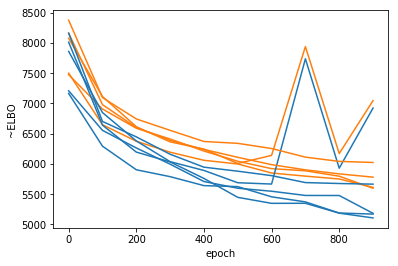

In [394]:
for i in range(LOGS):
    m, trl, tel = semi_log[i]
    plt.plot(range(0, epochs, 100), trl, color='C0')
    plt.plot(range(0, epochs, 100), tel, color='C1')
plt.xlabel('epoch')
plt.ylabel('~ELBO')

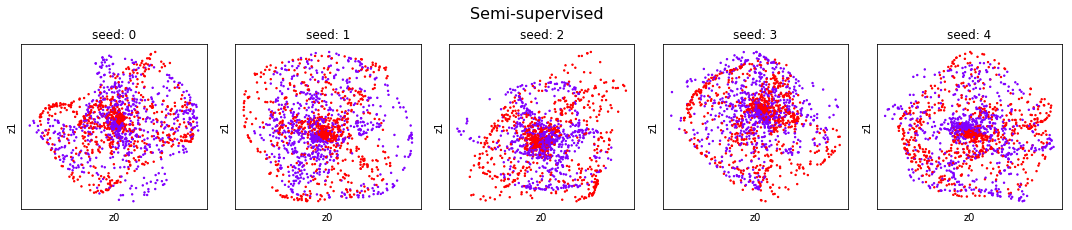

In [465]:
plot2d_latent(semi_log, 'semi_latent', 'Semi-supervised')

In [396]:
latent_dim = 2
SS_MOD = 'weak'

In [397]:
weak_log = []
for _ in range(LOGS):
    m, trl, tel = fit_model_report(100)
    weak_log.append((m, trl, tel))

conv size: 335
fc3 4 20
epoch: 100
====> Test set loss: 7895.7749, MSE: 149.0399, CE: 0.0000, CE(full): 2.2909, KL: 887.5640
0.3588593974175036
0.35885939741750356
epoch: 200
====> Test set loss: 7304.2417, MSE: 135.7892, CE: 0.0000, CE(full): 2.0440, KL: 1029.5684
0.3817790530846485
0.3817790530846485
epoch: 300
====> Test set loss: 7060.8027, MSE: 130.5613, CE: 0.0000, CE(full): 2.1541, KL: 1065.4780
0.36276901004304163
0.36276901004304163
epoch: 400
====> Test set loss: 6815.6475, MSE: 125.4796, CE: 0.0000, CE(full): 2.1962, KL: 1083.3386
0.40046628407460544
0.4004662840746055
epoch: 500
====> Test set loss: 6693.7744, MSE: 122.8973, CE: 0.0000, CE(full): 2.1374, KL: 1097.8179
0.40512912482066
0.40512912482066
epoch: 600
====> Test set loss: 6606.6411, MSE: 121.8418, CE: 0.0000, CE(full): 2.1611, KL: 1029.1010
0.39730989956958396
0.3973098995695839
epoch: 700
====> Test set loss: 6522.8911, MSE: 119.9583, CE: 0.0000, CE(full): 2.0720, KL: 1049.9534
0.4061334289813486
0.4061334289813

Text(0,0.5,'~ELBO')

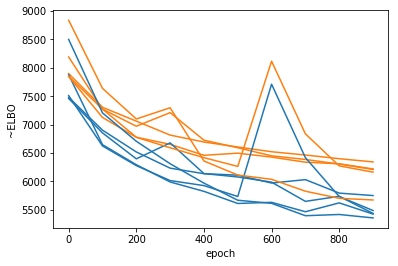

In [398]:
for i in range(LOGS):
    m, trl, tel = weak_log[i]
    plt.plot(range(0, epochs, 100), trl, color='C0')
    plt.plot(range(0, epochs, 100), tel, color='C1')
plt.xlabel('epoch')
plt.ylabel('~ELBO')

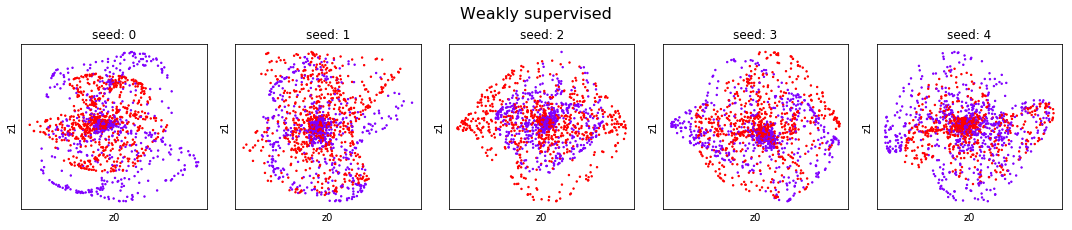

In [466]:
plot2d_latent(weak_log, 'weak_latent', 'Weakly supervised')

In [400]:
latent_dim = 2
SS_MOD = None

In [401]:
unsup_log = []
for _ in range(LOGS):
    m, trl, tel = fit_model_report(100)
    unsup_log.append((m, trl, tel))

conv size: 335
fc3 2 10
epoch: 100
====> Test set loss: 8601.4268, MSE: 162.6367, CE: 0.0000, CE(full): 0.7108, KL: 939.1824
0.3801470588235294
0.3801470588235294
epoch: 200
====> Test set loss: 8215.0283, MSE: 153.0830, CE: 0.0000, CE(full): 0.7108, KL: 1121.7593
0.3801470588235294
0.3801470588235294
epoch: 300
====> Test set loss: 8088.4683, MSE: 149.3108, CE: 0.0000, CE(full): 0.7108, KL: 1245.8522
0.3801470588235294
0.3801470588235294
epoch: 400
====> Test set loss: 7969.0054, MSE: 146.6259, CE: 0.0000, CE(full): 0.7108, KL: 1275.4193
0.3801470588235294
0.3801470588235294
epoch: 500
====> Test set loss: 7933.0332, MSE: 145.2771, CE: 0.0000, CE(full): 0.7108, KL: 1338.3534
0.3801470588235294
0.3801470588235294
epoch: 600
====> Test set loss: 7873.4243, MSE: 144.0521, CE: 0.0000, CE(full): 0.7108, KL: 1341.6393
0.3801470588235294
0.3801470588235294
epoch: 700
====> Test set loss: 7789.2622, MSE: 141.6309, CE: 0.0000, CE(full): 0.7108, KL: 1415.4385
0.3801470588235294
0.38014705882352

Text(0,0.5,'~ELBO')

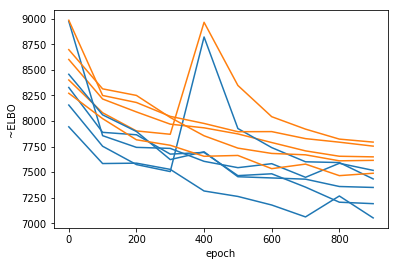

In [402]:
for i in range(LOGS):
    m, trl, tel = unsup_log[i]
    plt.plot(range(0, epochs, 100), trl, color='C0')
    plt.plot(range(0, epochs, 100), tel, color='C1')
plt.xlabel('epoch')
plt.ylabel('~ELBO')

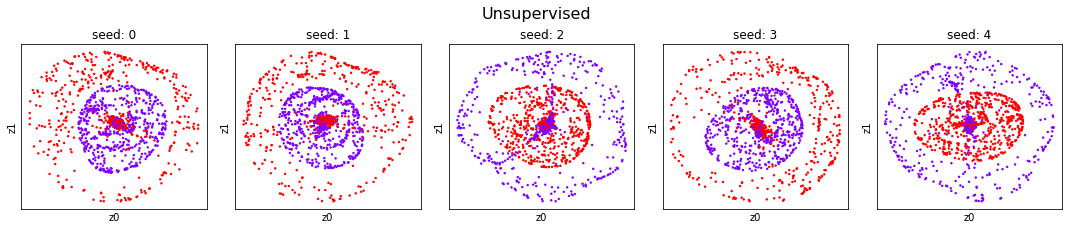

In [467]:
plot2d_latent(unsup_log, 'unusp_latent', 'Unsupervised')

In [404]:
latent_dim = 2 + num_labels
SS_MOD = None

In [405]:
unsupext_log = []
for _ in range(LOGS):
    m, trl, tel = fit_model_report(100)
    unsupext_log.append((m, trl, tel))

conv size: 335
fc3 4 20
epoch: 100
====> Test set loss: 7199.7021, MSE: 124.9476, CE: 0.0000, CE(full): 0.7338, KL: 1904.6487
0.39451219512195124
0.39451219512195124
epoch: 200
====> Test set loss: 6669.7202, MSE: 115.5823, CE: 0.0000, CE(full): 0.7338, KL: 1781.2145
0.39451219512195124
0.39451219512195124
epoch: 300
====> Test set loss: 6353.5376, MSE: 106.5600, CE: 0.0000, CE(full): 0.7338, KL: 2051.0742
0.39451219512195124
0.39451219512195124
epoch: 400
====> Test set loss: 6142.2861, MSE: 102.7839, CE: 0.0000, CE(full): 0.7338, KL: 2006.1792
0.39451219512195124
0.39451219512195124
epoch: 500
====> Test set loss: 6115.0781, MSE: 100.7166, CE: 0.0000, CE(full): 0.7338, KL: 2158.4927
0.39451219512195124
0.39451219512195124
epoch: 600
====> Test set loss: 5859.3809, MSE: 95.5439, CE: 0.0000, CE(full): 0.7338, KL: 2164.3691
0.39451219512195124
0.39451219512195124
epoch: 700
====> Test set loss: 5753.1948, MSE: 93.0073, CE: 0.0000, CE(full): 0.7338, KL: 2205.6555
0.39451219512195124
0.39

Text(0,0.5,'~ELBO')

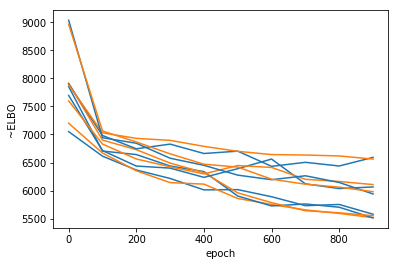

In [406]:
for i in range(LOGS):
    m, trl, tel = unsupext_log[i]
    plt.plot(range(0, epochs, 100), trl, color='C0')
    plt.plot(range(0, epochs, 100), tel, color='C1')
plt.xlabel('epoch')
plt.ylabel('~ELBO')

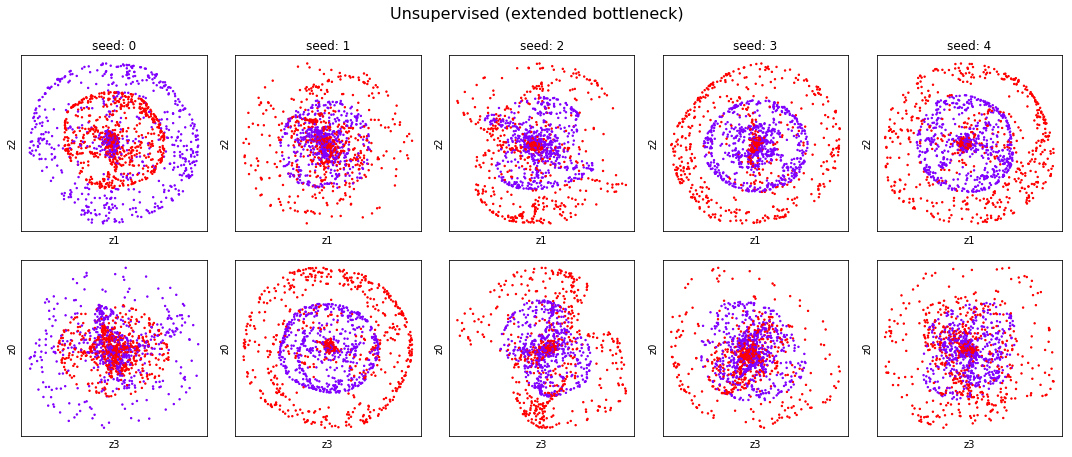

In [468]:
plt.figure(figsize=(3*LOGS, 6))
for i in range(LOGS):
    plt.subplot(2, LOGS, i + 1)
    m, trl, tel = unsupext_log[i]
    _, mu, logvar, _ = m(ts_dataset_train[:len(ts_dataset_train)][0].to(device))
    plt.scatter(mu.to(torch.device("cpu")).data.numpy()[:, 1], mu.to(torch.device("cpu")).data.numpy()[:, 2], 
                s=2, c=ts_dataset_train[:len(ts_dataset_train)][2], cmap=cm.rainbow)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title(f'seed: {i}')
    plt.subplot(2, LOGS, i + 1 + LOGS)
    plt.scatter(mu.to(torch.device("cpu")).data.numpy()[:, 0], mu.to(torch.device("cpu")).data.numpy()[:, 3], 
                s=2, c=ts_dataset_train[:len(ts_dataset_train)][2], cmap=cm.rainbow)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('z3')
    plt.ylabel('z0')
plt.tight_layout()
plt.suptitle('Unsupervised (extended bottleneck)', fontsize=16, y=1.05)
plt.savefig('unsupext_latent.png', dpi=300, bbox_to_anchor=(1, 1), bbox_extra_artists=(lgd,), bbox_inches='tight')

array([7892.93371582, 7251.00039063, 6451.77001953, 6103.2182373 ,
       6479.92133789, 5782.50576172, 5713.57648926, 5421.52106934,
       5405.33376465, 5552.15847168])

In [434]:
def plot_loss(ts, label, c):
    ts = np.array(ts)
    mean = np.mean(ts, axis=0)
    R = np.max(ts, axis=0)
    L = np.min(ts, axis=0)
    plt.plot(np.arange(0, epochs, 100), mean, label=label, color=c)
    plt.plot(np.arange(0, epochs, 100), R, color=c, linestyle='--', lw=1, alpha=0.5)
    plt.plot(np.arange(0, epochs, 100), L, color=c, linestyle='--', lw=1, alpha=0.5)

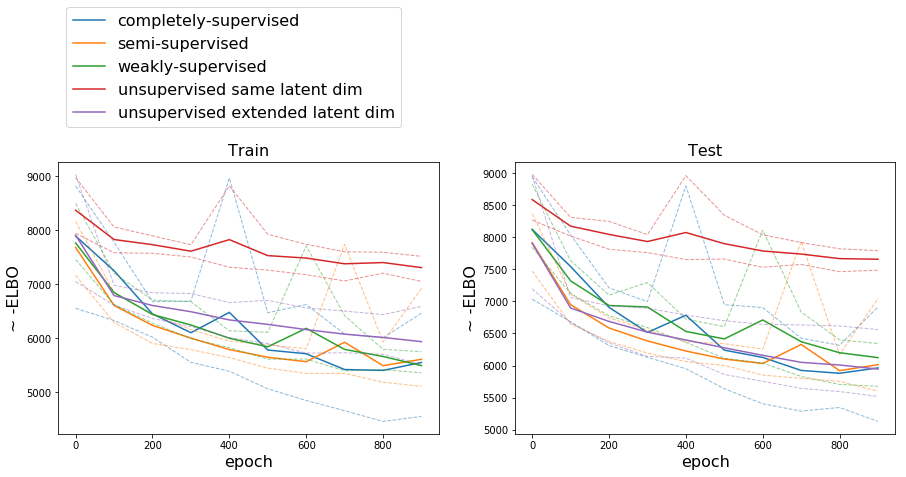

In [469]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Train',fontsize=16)
plot_loss([x[1] for x in full_log], 'completely-supervised', 'C0')
plot_loss([x[1] for x in semi_log], 'semi-supervised', 'C1')
plot_loss([x[1] for x in weak_log], 'weakly-supervised', 'C2')
plot_loss([x[1] for x in unsup_log], 'unsupervised same latent dim', 'C3')
plot_loss([x[1] for x in unsupext_log], 'unsupervised extended latent dim', 'C4')
plt.xlabel('epoch',fontsize=16)
plt.ylabel('~ -ELBO',fontsize=16)
lgd = plt.legend(loc=2, bbox_to_anchor=(0, 1.6), fontsize=16)
plt.subplot(1, 2, 2)
plt.title('Test',fontsize=16)
plot_loss([x[2] for x in full_log], 'completely-supervised', 'C0')
plot_loss([x[2] for x in semi_log], 'semi-supervised', 'C1')
plot_loss([x[2] for x in weak_log], 'weakly-supervised', 'C2')
plot_loss([x[2] for x in unsup_log], 'unsupervised same latent dim', 'C3')
plot_loss([x[2] for x in unsupext_log], 'unsupervised extended latent dim', 'C4')
plt.xlabel('epoch',fontsize=16)
plt.ylabel('~ -ELBO',fontsize=16)

plt.savefig('loss_results.png', dpi=300, bbox_to_anchor=(1, 1), bbox_extra_artists=(lgd,), bbox_inches='tight')

In [470]:
def save_ts_image(ts_tensor, file_path, nrow=1, h=1, w=3, off_axis=False):
    ncol = int(np.ceil(len(ts_tensor)/float(nrow)))
    plt.figure(figsize=(w*nrow, h*ncol))
    for i in range(len(ts_tensor)):
        plt.subplot(ncol, nrow, i + 1)
        plt.plot(ts_tensor[i].data.numpy())
        if off_axis:
            plt.xticks([])
            plt.yticks([])
    plt.tight_layout()
    plt.savefig(file_path, bbox_inches='tight', dpi=100)
    plt.close()

In [471]:
step = 10

In [532]:
model=full_log[1][0]

In [533]:
data = ts_dataset_train[:][0].to(device)
labels = ts_dataset_train[:][2].to(device)
recon_batch, mu, logvar, y_pred = model(data)

In [534]:
h = np.linspace(-3, 3, step)
S = np.meshgrid(h, h) 
S = np.hstack((S[0].ravel().reshape(-1, 1), S[1].ravel().reshape(-1, 1))) + mu.to(torch.device("cpu")).data.numpy().mean(axis=0)

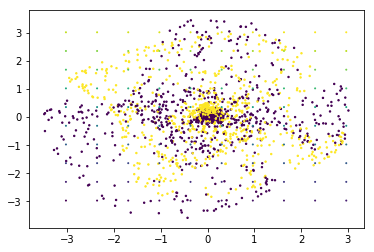

In [535]:
plt.scatter(mu.to(torch.device("cpu")).data.numpy()[:, 0], 
            mu.to(torch.device("cpu")).data.numpy()[:, 1], s=2, c=labels)
plt.scatter(S[:, 0], S[:, 1], c = np.arange(len(S)), s=1)

In [536]:
R1 = model.decode(torch.Tensor(S).to(device), (-10*one_hot_encoding(torch.ones(len(S)).long())).to(device)).to(torch.device("cpu"))

In [537]:
R2 = model.decode(torch.Tensor(S).to(device), (-10*one_hot_encoding(torch.zeros(len(S)).long())).to(device)).to(torch.device("cpu"))

In [538]:
save_ts_image(R1, 'results/R1.png', nrow=step, w=1, off_axis=True)
save_ts_image(R2, 'results/R2.png', nrow=step, w=1, off_axis=True)